<a href="https://colab.research.google.com/github/Niashr/GoogleColab/blob/master/Classification_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tf-nightly

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive/ImageClassification

ln: failed to create symbolic link '/mydrive/My Drive': File exists
11train  11validation  Test


In [ ]:
!ls /mydrive/ImageClassification

11train  11validation  Test


In [ ]:
PATH = '/mydrive/ImageClassification'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
print(train_dir)
print(validation_dir)

/mydrive/ImageClassification/train
/mydrive/ImageClassification/validation


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
batch_size = 32

train_dataset = train_datagen.flow_from_directory(
                PATH,
                target_size = (224,224),
                class_mode = 'categorical',
                batch_size = batch_size,
                shuffle = True
                )

test_dataset = test_datagen.flow_from_directory(
                PATH,
                target_size = (224,224),
                class_mode = 'categorical',
                batch_size = batch_size,
                shuffle = True
                )

Found 699 images belonging to 3 classes.
Found 699 images belonging to 3 classes.


In [ ]:
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)


BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 702 files belonging to 2 classes.


In [ ]:
print(train_dataset.class_names)

NameError: ignored

In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 560 files belonging to 2 classes.


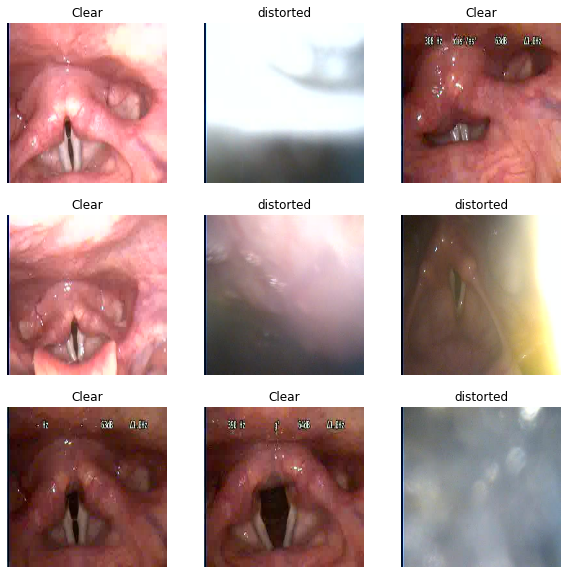

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print(validation_dataset)

Number of validation batches: 15
Number of test batches: 3
<SkipDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.6),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.8),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2)
])

Let's repeatedly apply these layers to the same image and see the result.

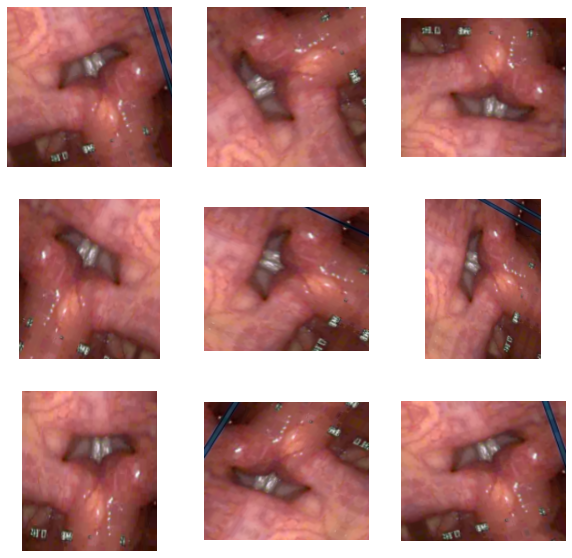

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values


In [ ]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.resnetv2( weights='imagenet', input_shape=IMG_SHAPE, classes=2)
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

219062272/219055592 [==============================] - 1s 0us/step


In [ ]:
IMG_SHAPE

(160, 160, 3)

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1536)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1537  

In [ ]:
len(model.trainable_variables)

2

### Train the model



In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

15/15 [==============================] - 283s 5s/step - loss: 1.4813 - accuracy: 0.3638


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.45
initial accuracy: 0.39


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
22/22 [==============================] - 217s 10s/step - loss: 1.1948 - accuracy: 0.3832 - val_loss: 1.0062 - val_accuracy: 0.4246
Epoch 2/10
22/22 [==============================] - 113s 5s/step - loss: 0.7731 - accuracy: 0.5385 - val_loss: 1.0618 - val_accuracy: 0.4957
Epoch 3/10
22/22 [==============================] - 114s 5s/step - loss: 0.6636 - accuracy: 0.6011 - val_loss: 0.9236 - val_accuracy: 0.5000
Epoch 4/10
22/22 [==============================] - 114s 5s/step - loss: 0.5759 - accuracy: 0.6709 - val_loss: 0.8019 - val_accuracy: 0.5539
Epoch 5/10
22/22 [==============================] - 114s 5s/step - loss: 0.4709 - accuracy: 0.7450 - val_loss: 0.7327 - val_accuracy: 0.5625
Epoch 6/10
22/22 [==============================] - 113s 5s/step - loss: 0.4200 - accuracy: 0.7835 - val_loss: 0.6769 - val_accuracy: 0.5991
Epoch 7/10
22/22 [==============================] - 113s 5s/step - loss: 0.3640 - accuracy: 0.8134 - val_loss: 0.6473 - val_accuracy: 0.6142
Epoch 8/10
2

In [ ]:
model.save('inception_resnet_v2_1.h5')

### Learning curves


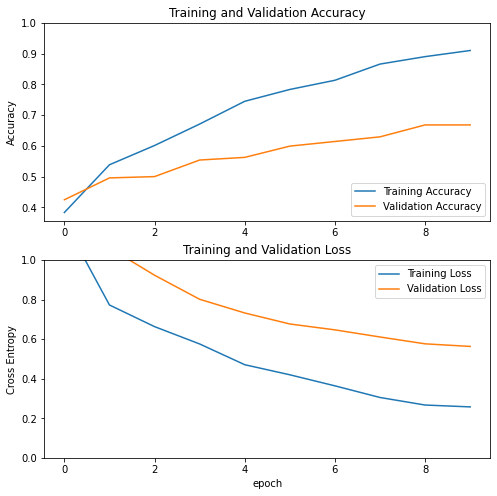

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 10s 3s/step - loss: 0.5728 - accuracy: 0.6771
Test accuracy : 0.6770833134651184


Predictions:
 [1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0]
Labels:
 [0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1]


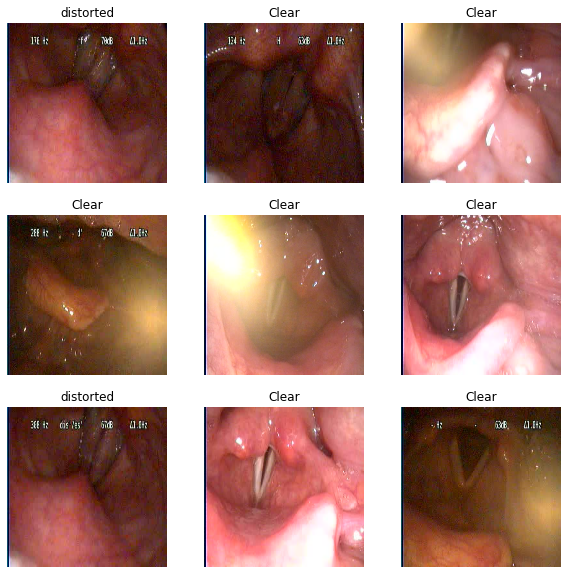

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
# do predictions

#  perform confusion matrix

### Un-freeze the top layers of the model


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 770

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


### Compile the model


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1537  

In [ ]:
len(model.trainable_variables)

8

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
22/22 [==============================] - 131s 6s/step - loss: 0.1560 - accuracy: 0.9518 - val_loss: 0.3804 - val_accuracy: 0.8103
Epoch 11/15
22/22 [==============================] - 118s 5s/step - loss: 0.0587 - accuracy: 0.9938 - val_loss: 0.3283 - val_accuracy: 0.8319
Epoch 12/15
22/22 [==============================] - 112s 5s/step - loss: 0.0389 - accuracy: 0.9946 - val_loss: 0.3157 - val_accuracy: 0.8685
Epoch 13/15
22/22 [==============================] - 113s 5s/step - loss: 0.0244 - accuracy: 0.9990 - val_loss: 0.2945 - val_accuracy: 0.8750
Epoch 14/15
22/22 [==============================] - 110s 5s/step - loss: 0.0148 - accuracy: 0.9978 - val_loss: 0.2943 - val_accuracy: 0.8750
Epoch 15/15
22/22 [==============================] - 114s 5s/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.2895 - val_accuracy: 0.8793


In [ ]:
model.save('/content/inception_resnet_v2_2')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /content/inception_resnet_v2_2/assets


AttributeError: ignored

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

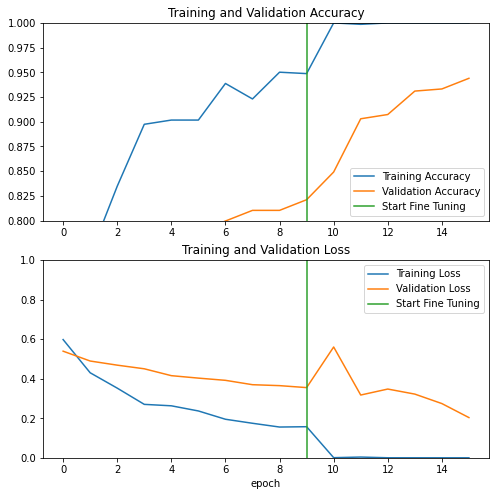

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 8s 2s/step - loss: 0.3406 - accuracy: 0.9271
Test accuracy : 0.9270833134651184


Predictions:
 [0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0]
Labels:
 [0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0]


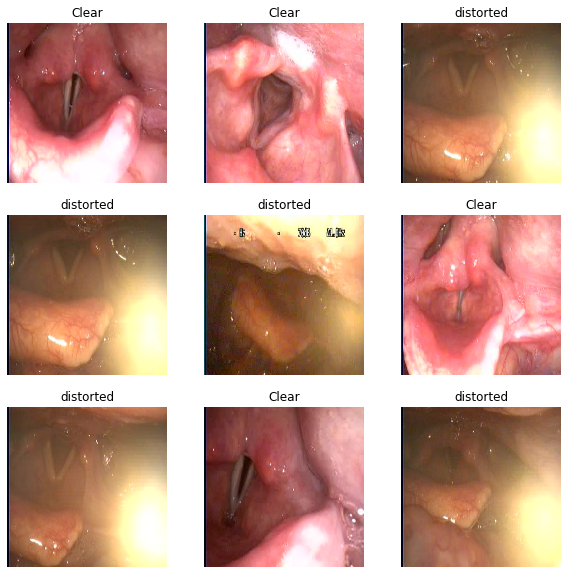

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
tf.math.confusion_matrix(label_batch, predictions, num_classes=2, weights=None, dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[17,  1],
       [ 0, 14]], dtype=int32)>